In [11]:
library('SGL')
library('grpregOverlap')
library('MASS')

In [12]:
df <- read.csv('/homes/gws/psturm/simulatedData/regressionData/df0.csv', header=TRUE)
df = as.data.frame(df)

In [13]:
df_t = as.data.frame(t(df))
colnames(df_t) = c(paste('p', sep='', 1:10), paste('g', sep='', 1:1000))
data_mat = df_t[1:100, ]

In [140]:
group_index <- unlist(df['gene_group'][-(1:10), ])

In [91]:
y <- data_mat$p1
x <- data.matrix(data_mat[, paste('g', sep='', 1:1000)])

In [15]:
library('glmnet')

In [117]:
alphalist <- seq(0,1,by=0.1)
elasticnet <- lapply(alphalist, function(a){
  cv.glmnet(x, y, alpha=a)
})

In [118]:
elasticnet_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(elasticnet, function(o) {o$lambda.min}))), 
                            'cvm' = as.numeric(unlist(lapply(elasticnet, function(o) {
                                o$cvm[o$lambda == o$lambda.min]}))),
                            'cvsd' = as.numeric(unlist(lapply(elasticnet, function(o) {
                                o$cvsd[o$lambda == o$lambda.min]}))),
                            'alpha' = alphalist)

In [119]:
elasticnet_df

lambda.min,cvm,cvsd,alpha
7.673469205,0.2868251,0.05802981,0.0
0.080388472,0.1175477,0.01403119,0.1
0.040194236,0.1164194,0.01176121,0.2
0.040727777,0.1294264,0.02251210,0.3
0.022056562,0.1177432,0.01654030,0.4
0.016077694,0.1088795,0.02480033,0.5
0.014036038,0.1232367,0.02138055,0.6
0.025323870,0.1207548,0.02307347,0.7
0.014578739,0.1155649,0.02189733,0.8
0.008932052,0.1207302,0.02782604,0.9


In [120]:
typeof(elasticnet_df$alpha)

[1] "double"

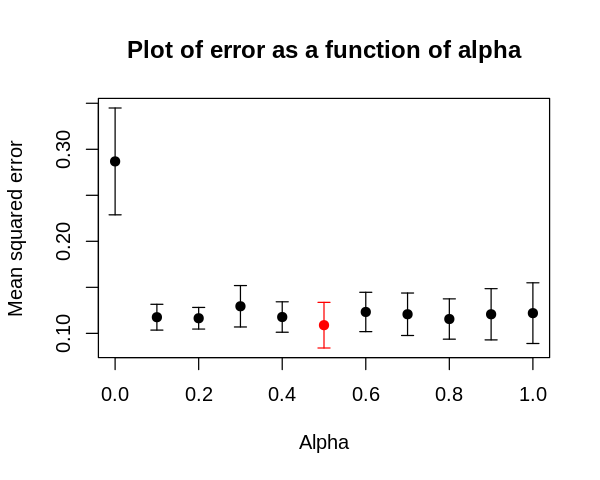

In [122]:
best_alpha <- elasticnet_df[elasticnet_df$cvm == min(elasticnet_df$cvm),]$alpha
best_lambda <- elasticnet_df[elasticnet_df$cvm == min(elasticnet_df$cvm),]$lambda.min
plot(elasticnet_df$alpha, elasticnet_df$cvm,
     ylim=range(c(elasticnet_df$cvm-elasticnet_df$cvsd, elasticnet_df$cvm+elasticnet_df$cvsd)),
     pch=19, xlab="Alpha", ylab="Mean squared error",
     main="Plot of error as a function of alpha",
     col=ifelse(elasticnet_df$alpha==best_alpha, "red", "black")
    )
arrows(elasticnet_df$alpha, elasticnet_df$cvm-elasticnet_df$cvsd, 
       elasticnet_df$alpha, elasticnet_df$cvm+elasticnet_df$cvsd, 
       length=0.05, angle=90, code=3,
       col=ifelse(elasticnet_df$alpha==best_alpha, "red", "black"))

In [130]:
cat(sprintf('Elastic net: best alpha = %f, best lambda = %f', best_alpha, best_lambda))

Elastic net: best alpha = 0.500000, best lambda = 0.016078

In [161]:
alphalist <- seq(0,1,by=0.1)
sparse_gl <- lapply(alphalist, function(a){
  cvSGL(data=list(x=x, y=y), index=group_index, min.frac=0.01, type="linear", alpha=a)
})

In [173]:
names(sparse_gl[[6]])

[1] "fit"     "lldiff"  "lambdas" "type"    "llSD"

In [190]:
sparse_gl_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                            o$lambdas[o$lldiff == min(o$lldiff)]}))), 
                            'nll' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                                min(o$lldiff)}))),
                            'nllsd' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                                o$llSD[o$lldiff == min(o$lldiff)]}))),
                            'alpha' = alphalist)
sparse_gl_df

lambda.min,nll,nllsd,alpha
0.0008916101,46.85303,7.825006,0.0
0.0009123253,45.35427,11.202766,0.1
0.0009376265,44.49379,8.890506,0.2
0.0009690195,48.65491,11.298826,0.3
0.0012838768,41.05301,9.679451,0.4
0.0010560365,44.83996,9.405043,0.5
0.0011203666,45.40412,13.341604,0.6
0.0009492706,50.27063,11.096366,0.7
0.0093681858,59.81065,15.373660,0.8
0.0009825607,54.04654,15.718310,0.9


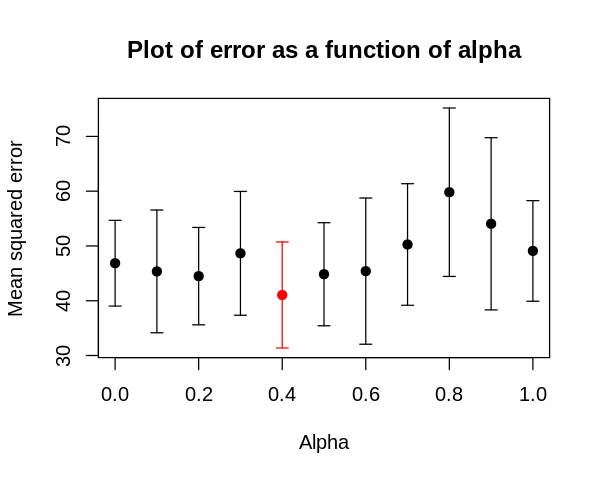

In [194]:
best_alpha_sgl <- sparse_gl_df[sparse_gl_df$nll == min(sparse_gl_df$nll),]$alpha
best_lambda_sgl <- sparse_gl_df[sparse_gl_df$nll == min(sparse_gl_df$nll),]$lambda.min
plot(sparse_gl_df$alpha, sparse_gl_df$nll,
     ylim=range(c(sparse_gl_df$nll-sparse_gl_df$nllsd, sparse_gl_df$nll+sparse_gl_df$nllsd)),
     pch=19, xlab="Alpha", ylab="Mean squared error",
     main="Plot of error as a function of alpha",
     col=ifelse(sparse_gl_df$alpha==best_alpha_sgl, "red", "black")
    )
arrows(sparse_gl_df$alpha, sparse_gl_df$nll-sparse_gl_df$nllsd, 
       sparse_gl_df$alpha, sparse_gl_df$nll+sparse_gl_df$nllsd, 
       length=0.05, angle=90, code=3,
       col=ifelse(sparse_gl_df$alpha==best_alpha_sgl, "red", "black"))

In [196]:
cat(sprintf('Sparse Group Lasso: best alpha = %f, best lambda = %f', best_alpha_sgl, best_lambda_sgl))

Sparse Group Lasso: best alpha = 0.400000, best lambda = 0.001284

In [240]:
group_df <- lapply(unique(group_index), function(o, gi) { 
    paste('g', which(group_index == 0), sep='')
}, 
group_index)

In [245]:
alphalist <- seq(0.1,1,by=0.1)
overlap_gl <- lapply(alphalist, function(a){
  cv.grpregOverlap(x, y, group_df, penalty="grLasso", alpha=a)
})

In [249]:
overlap_gl_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(overlap_gl, function(o) {
                            o$lambda[o$cve == min(o$cve)]}))), 
                            'cve' = as.numeric(unlist(lapply(overlap_gl, function(o) {
                                min(o$cve)}))),
                            'cvse' = as.numeric(unlist(lapply(overlap_gl, function(o) {
                                o$cvse[o$cve == min(o$cve)]}))),
                            'alpha' = alphalist)
overlap_gl_df

lambda.min,cve,cvse,alpha
0.08727587,0.4126314,0.05488402,0.1
0.04636045,0.4200779,0.05504586,0.2
0.05015611,0.4574401,0.06060558,0.3
0.04649188,0.3542762,0.04657985,0.4
0.02586822,0.3867573,0.05237964,0.5
0.01744188,0.4268944,0.06077347,0.6
0.02085477,0.3750493,0.04922529,0.7
0.02396011,0.4193196,0.06147810,0.8
0.01622037,0.5373674,0.08686251,0.9
0.01975698,0.4282366,0.05590570,1.0


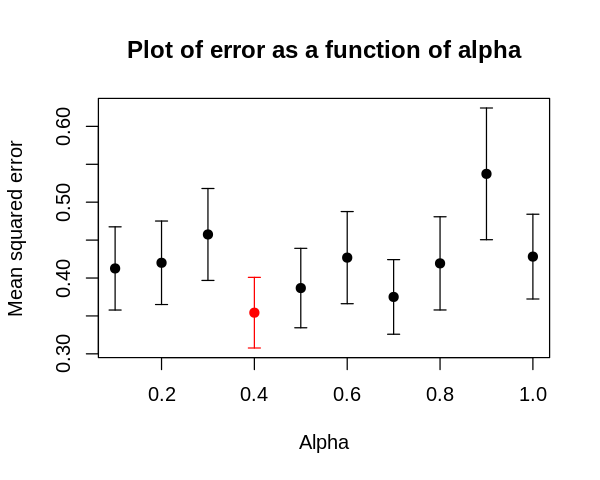

In [250]:
best_alpha_ovl <- overlap_gl_df[overlap_gl_df$cve == min(overlap_gl_df$cve),]$alpha
best_lambda_ovl <- overlap_gl_df[overlap_gl_df$cve == min(overlap_gl_df$cve),]$lambda.min
plot(overlap_gl_df$alpha, overlap_gl_df$cve,
     ylim=range(c(overlap_gl_df$cve-overlap_gl_df$cvse, overlap_gl_df$cve+overlap_gl_df$cvse)),
     pch=19, xlab="Alpha", ylab="Mean squared error",
     main="Plot of error as a function of alpha",
     col=ifelse(overlap_gl_df$alpha==best_alpha_ovl, "red", "black")
    )
arrows(overlap_gl_df$alpha, overlap_gl_df$cve-overlap_gl_df$cvse, 
       overlap_gl_df$alpha, overlap_gl_df$cve+overlap_gl_df$cvse, 
       length=0.05, angle=90, code=3,
       col=ifelse(overlap_gl_df$alpha==best_alpha_ovl, "red", "black"))

In [251]:
cat(sprintf('Overlapping Group Lasso: best alpha = %f, best lambda = %f', best_alpha_ovl, best_lambda_ovl))

Overlapping Group Lasso: best alpha = 0.400000, best lambda = 0.046492